In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 58.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pennylane as qml
from sklearn.model_selection import train_test_split

X = torch.linspace(-1, 1, 1000).unsqueeze(1)
y = torch.tanh(10 * X + 0.5 + F.relu(X ** 2) * 10).squeeze()  # f(x)


/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


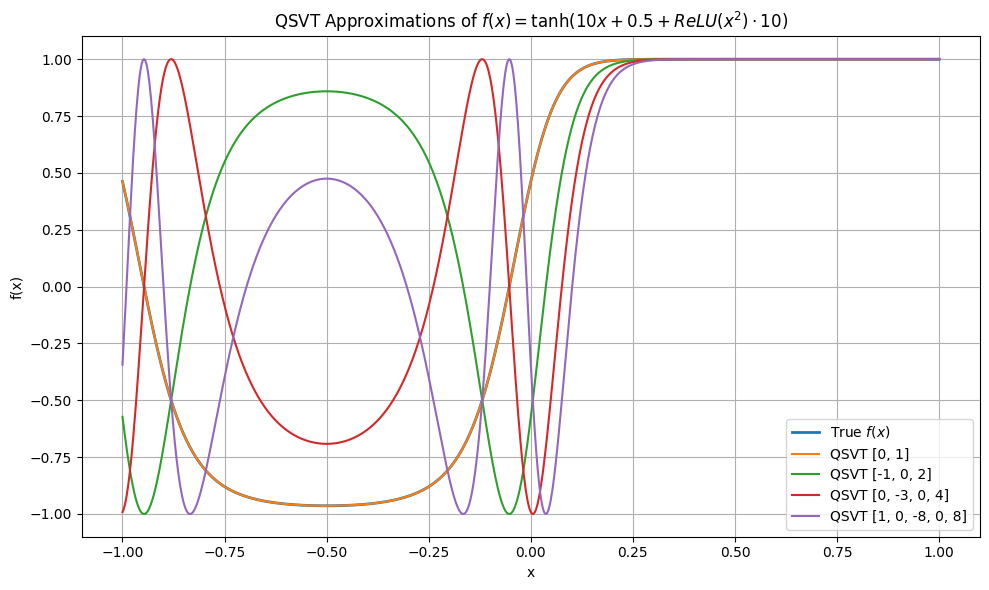

In [ ]:
import numpy as np

def target_function(x):
    return np.tanh(10 * x + 0.5 + np.maximum(0, x**2) * 10)

target_polys = [
    [0, 1],
    [-1, 0, 2],
    [0, -3, 0, 4],
    [1, 0, -8, 0, 8]
]

x_vals = np.linspace(-1, 1, 1000)
f_vals = target_function(x_vals)


padded_dim = 1024
eigvals_padded = np.zeros(padded_dim)
eigvals_padded[:1000] = f_vals
A = np.diag(eigvals_padded)

wire_order = list(range(int(np.log2(padded_dim)+1)))

results = {}
for i, poly in enumerate(target_polys):
    try:
        U_A = qml.matrix(qml.qsvt, wire_order=wire_order)(
            A, poly, encoding_wires=wire_order, block_encoding="embedding"
        )
        qsvt_diag = np.real(np.diagonal(U_A))[:1000]
        results[i] = qsvt_diag
    except Exception as e:
        print(f"Error for polynomial {poly}: {e}")
        results[i] = None

plt.figure(figsize=(10, 6))
plt.plot(x_vals, f_vals, label="True $f(x)$", linewidth=2)

for i, poly in enumerate(target_polys):
    if results[i] is not None:
        plt.plot(x_vals, results[i], label=f"QSVT {poly}")

plt.title("QSVT Approximations of $f(x) = \\tanh(10x + 0.5 + ReLU(x^2)\\cdot10)$")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print(qsvt_outputs.shape)

(1000, 4)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(qsvt_outputs, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(800, 4)
torch.Size([800])


In [ ]:
dev = qml.device("default.qubit", wires=3)  # 2 control + 1 target

def quantum_lcu_block(qsvt_vals, weight_vals):
    """Differentiable quantum circuit with parameter tracking"""
    # norm = torch.norm(weight_vals) + 1e-8
    # alpha = weight_vals / norm

    alpha = torch.sqrt(torch.abs(weight_vals) + 1e-8)
    norm = torch.norm(alpha) + 1e-8
    alpha = alpha / norm

    @qml.qnode(dev, interface="torch", diff_method="backprop")

    def circuit():
        qml.StatePrep(alpha, wires=[0,1])
        for r in range(4):
            ctrl_state = [int(b) for b in f"{r:02b}"]
            qml.ctrl(qml.RY, control=[0,1], control_values=ctrl_state)(2*qsvt_vals[r], wires=2)
        qml.adjoint(qml.StatePrep(alpha, wires=[0,1]))

        return qml.expval(qml.PauliZ(2))

    return circuit()


In [ ]:
class KANLayer(nn.Module):
    def __init__(self, in_features, out_features, num_basis=10):
        super(KANLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_basis = num_basis
        self.weights = nn.Parameter(torch.randn(out_features, in_features, num_basis))
        self.bias = nn.Parameter(torch.randn(out_features))
        self.knots = nn.Parameter(torch.linspace(-2, 2, num_basis).float())



    def forward(self, x):
        x = x.float()
        weights = self.weights.float()
        bias = self.bias.float()
        knots = self.knots.to(x.device).float()

        x_expanded = x.unsqueeze(-1).expand(-1, -1, self.num_basis)
        knot_distances = torch.abs(x_expanded - knots)
        basis_values = torch.exp(-knot_distances ** 2)
        transformed = torch.einsum('bij,kij->bk', basis_values, weights.to(x.device))
        return transformed + bias.to(x.device)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class QuantumLCULayer(nn.Module):
    def __init__(self, degree=4):
        super().__init__()
        self.degree = degree
        self.lcu_weights = nn.Parameter(torch.rand(degree))

    def forward(self, qsvt_outputs):  
        N = qsvt_outputs.shape[0]
        quantum_phi_outputs = []
        p_phi_vals = []
        for i in range(N):
            qsvt_vec = qsvt_outputs[i, :]            
            weight_vec = self.lcu_weights           
            phi_val = quantum_lcu_block(qsvt_vec, weight_vec)
            phi_tensor = torch.tensor([phi_val])
            p_phi_vals.append(phi_val)  

        return torch.stack(p_phi_vals).unsqueeze(1) 



In [ ]:
class HybridQuantumKANRegressor(nn.Module):
    def __init__(self, num_basis=10):
        super().__init__()
        self.quantum_layer = QuantumLCULayer(degree=4)
        self.kan_layer = KANLayer(in_features=1, out_features=1, num_basis=num_basis)

    def forward(self, x):  
        q_out = self.quantum_layer(x)    
        kan_out = self.kan_layer(q_out)   
        return kan_out


In [ ]:
print("X_train device:", X_train.device)
print("y_train device:", y_train.device)


X_train device: cuda:0
y_train device: cuda:0


In [ ]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np

class QuantumLCULayer(nn.Module):
    def __init__(self, degree=4, target_polys=None, padded_dim=1024):
        super().__init__()
        self.degree = degree
        self.padded_dim = padded_dim
        self.target_polys = target_polys or [
            [0, 1],
            [-1, 0, 2],
            [0, -3, 0, 4],
            [1, 0, -8, 0, 8]
        ]
        self.lcu_weights = nn.Parameter(torch.rand(degree))
        self.wire_order = list(range(int(np.log2(padded_dim)) + 1))
        self.dev = qml.device("default.qubit", wires=3)

    def quantum_lcu_block(self, qsvt_vals, weight_vals):
        alpha = torch.sqrt(torch.abs(weight_vals) + 1e-8)
        norm = torch.norm(alpha) + 1e-8
        alpha = alpha / norm

        @qml.qnode(self.dev, interface="torch", diff_method="backprop")
        def circuit():
            qml.StatePrep(alpha, wires=[0, 1])
            for r in range(self.degree):
                ctrl_state = [int(b) for b in f"{r:02b}"]
                qml.ctrl(qml.RY, control=[0, 1], control_values=ctrl_state)(2 * qsvt_vals[r], wires=2)
            qml.adjoint(qml.StatePrep(alpha, wires=[0, 1]))
            return qml.expval(qml.PauliZ(2))

        return circuit()

    def forward(self, x_vals): 
        N = x_vals.shape[0]
        x_np = x_vals.cpu().numpy()

        
        sig = 1 / (1 + np.exp(-3 * x_np))  
        relu = np.maximum(0, np.sin(2 * x_np) + x_np ** 3)
        f_vals = sig + relu
        f_vals = f_vals.ravel()  

        
        eigvals_padded = np.zeros(self.padded_dim)
        eigvals_padded[:N] = f_vals
        A = np.diag(eigvals_padded)

        
        qsvt_outputs = []
        for poly in self.target_polys:
            try:
                U_A = qml.matrix(qml.qsvt, wire_order=self.wire_order)(
                    A, poly, encoding_wires=self.wire_order, block_encoding="embedding"
                )
                diag_vals = np.real(np.diagonal(U_A))[:N]
                qsvt_outputs.append(torch.tensor(diag_vals, dtype=torch.float32))
            except Exception as e:
                print(f"QSVT failed for {poly}: {e}")
                qsvt_outputs.append(torch.zeros(N))

        
        qsvt_stack = torch.stack(qsvt_outputs, dim=1).to(x_vals.device)

        
        outputs = []
        for i in range(N):
            phi = self.quantum_lcu_block(qsvt_stack[i], self.lcu_weights)
            outputs.append(phi)

        return torch.stack(outputs).unsqueeze(1)  


In [ ]:
X = torch.linspace(-1, 1, 1000).unsqueeze(1)  
y = torch.sigmoid(3 * X) + F.relu(torch.sin(2 * X) + X ** 3)  
y = y.squeeze()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train dtype: torch.float32
weights dtype: torch.float32
knots dtype: torch.float32
Epoch 001 | Train Loss: 2.666695 | Test Loss: 2.367948
Epoch 002 | Train Loss: 2.424502 | Test Loss: 2.151558
Epoch 003 | Train Loss: 2.203557 | Test Loss: 1.955810
Epoch 004 | Train Loss: 2.003353 | Test Loss: 1.779823
Epoch 005 | Train Loss: 1.823004 | Test Loss: 1.622364
Epoch 006 | Train Loss: 1.661269 | Test Loss: 1.482096
Epoch 007 | Train Loss: 1.516804 | Test Loss: 1.357869
Epoch 008 | Train Loss: 1.388461 | Test Loss: 1.248784
Epoch 009 | Train Loss: 1.275351 | Test Loss: 1.154074
Epoch 010 | Train Loss: 1.176723 | Test Loss: 1.072977
Epoch 011 | Train Loss: 1.091834 | Test Loss: 1.004657
Epoch 012 | Train Loss: 1.019866 | Test Loss: 0.948171
Epoch 013 | Train Loss: 0.959894 | Test Loss: 0.902473
Epoch 014 | Train Loss: 0.910887 | Test Loss: 0.866426
Epoch 015 | Train Loss: 0.871722 | Test Loss: 0.838840
Epoch 016 | Train Loss: 0.841219 | Test Loss: 0.818500
Epoch 017 | Train Loss: 0.818174 | 

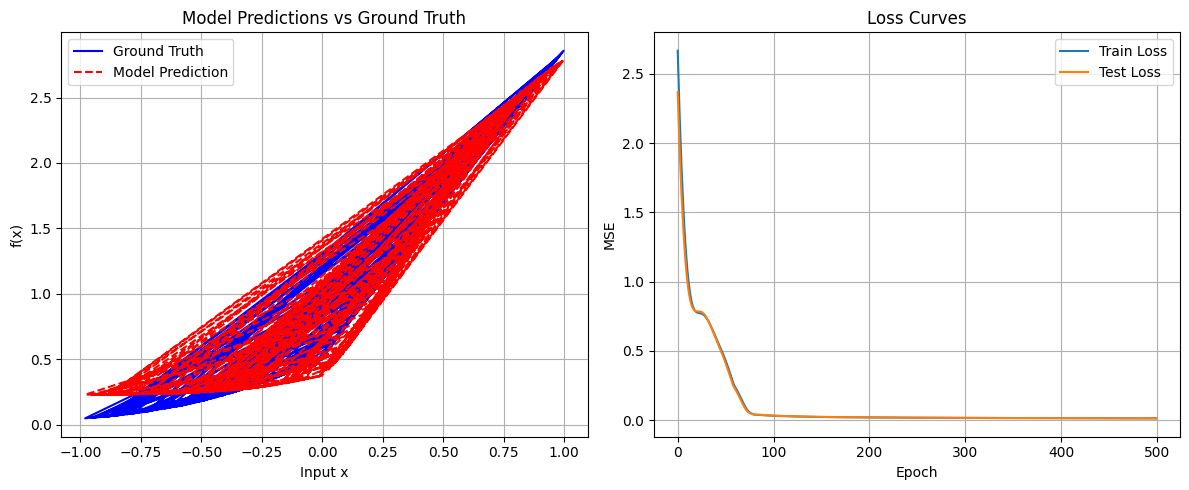

In [ ]:
model = HybridQuantumKANRegressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
X_train = X_train.float().to(device)
X_test = X_test.float().to(device)
y_train = y_train.float().to(device).view(-1, 1)
y_test = y_test.float().to(device).view(-1, 1)

print("X_train dtype:", X_train.dtype)
print("weights dtype:", model.kan_layer.weights.dtype)
print("knots dtype:", model.kan_layer.knots.dtype)

num_epochs = 500
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()


    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    print(f"Epoch {epoch+1:03d} | Train Loss: {loss.item():.6f} | Test Loss: {test_loss.item():.6f}")

model.eval()
with torch.no_grad():
    preds = model(X_test).cpu().numpy()
    true = y_test.cpu().numpy()
    x_plot = X_test.cpu().numpy().squeeze()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_plot, true, label='Ground Truth', color='blue')
plt.plot(x_plot, preds, label='Model Prediction', color='red', linestyle='--')
plt.title("Model Predictions vs Ground Truth")
plt.xlabel("Input x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


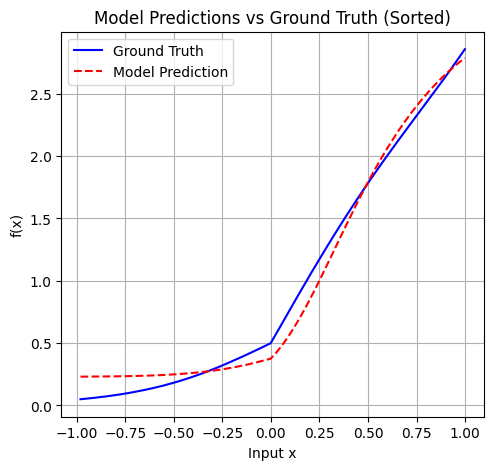

In [ ]:
model.eval()
with torch.no_grad():
  preds = model(X_test).cpu().numpy()
  true = y_test.cpu().numpy()
  x_plot = X_test.cpu().numpy().squeeze()
  sorted_indices = x_plot.argsort()
  x_sorted = x_plot[sorted_indices]
  true_sorted = true[sorted_indices]
  preds_sorted = preds[sorted_indices]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_sorted, true_sorted, label='Ground Truth', color='blue')
plt.plot(x_sorted, preds_sorted, label='Model Prediction', color='red', linestyle='--')
plt.title("Model Predictions vs Ground Truth (Sorted)")
plt.xlabel("Input x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)


In [ ]:
import torch
import torch.nn.functional as F

X = torch.linspace(-1, 1, 1000).unsqueeze(1)  

y_k = torch.tanh(5 * X - 2) + 3 * F.relu(torch.cos(X ** 2))
y_m = F.softplus(X ** 2 - 1) + torch.tanh(4 * X + 0.1)
y_k = y_k.squeeze()
y_m = y_m.squeeze()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_k, test_size=0.2, random_state=42)

In [ ]:
class QuantumLCULayer(nn.Module):
    def __init__(self, degree=4, target_polys=None, padded_dim=1024):
        super().__init__()
        self.degree = degree
        self.padded_dim = padded_dim
        self.target_polys = target_polys or [
            [0, 1],
            [-1, 0, 2],
            [0, -3, 0, 4],
            [1, 0, -8, 0, 8]
        ]
        self.lcu_weights = nn.Parameter(torch.rand(degree))
        self.wire_order = list(range(int(np.log2(padded_dim)) + 1))
        self.dev = qml.device("default.qubit", wires=3)

    def quantum_lcu_block(self, qsvt_vals, weight_vals):
        alpha = torch.sqrt(torch.abs(weight_vals) + 1e-8)
        norm = torch.norm(alpha) + 1e-8
        alpha = alpha / norm

        @qml.qnode(self.dev, interface="torch", diff_method="backprop")
        def circuit():
            qml.StatePrep(alpha, wires=[0, 1])
            for r in range(self.degree):
                ctrl_state = [int(b) for b in f"{r:02b}"]
                qml.ctrl(qml.RY, control=[0, 1], control_values=ctrl_state)(2 * qsvt_vals[r], wires=2)
            qml.adjoint(qml.StatePrep(alpha, wires=[0, 1]))
            return qml.expval(qml.PauliZ(2))

        return circuit()

    def forward(self, x_vals):  
        N = x_vals.shape[0]
        x_np = x_vals.cpu().numpy()

        
        k = np.tanh(5 * x_np - 2) + 3 * np.maximum(0, np.cos(x_np ** 2))
        f_vals = k
        f_vals = f_vals.ravel()  

        
        eigvals_padded = np.zeros(self.padded_dim)
        eigvals_padded[:N] = f_vals
        A = np.diag(eigvals_padded)

        
        qsvt_outputs = []
        for poly in self.target_polys:
            try:
                U_A = qml.matrix(qml.qsvt, wire_order=self.wire_order)(
                    A, poly, encoding_wires=self.wire_order, block_encoding="embedding"
                )
                diag_vals = np.real(np.diagonal(U_A))[:N]
                qsvt_outputs.append(torch.tensor(diag_vals, dtype=torch.float32))
            except Exception as e:
                print(f"QSVT failed for {poly}: {e}")
                qsvt_outputs.append(torch.zeros(N))

        
        qsvt_stack = torch.stack(qsvt_outputs, dim=1).to(x_vals.device)

        
        outputs = []
        for i in range(N):
            phi = self.quantum_lcu_block(qsvt_stack[i], self.lcu_weights)
            outputs.append(phi)

        return torch.stack(outputs).unsqueeze(1)  


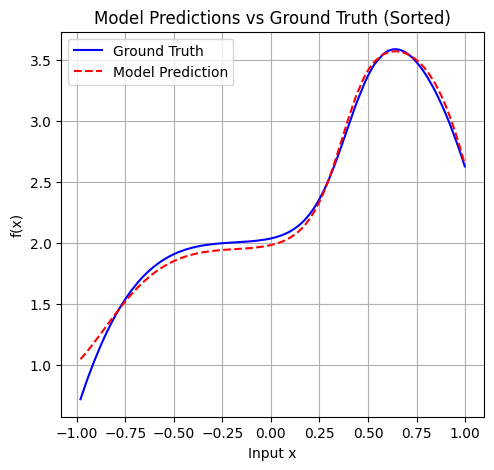

In [ ]:
model.eval()
with torch.no_grad():
  preds = model(X_test).cpu().numpy()
  true = y_test.cpu().numpy()
  x_plot = X_test.cpu().numpy().squeeze()
  sorted_indices = x_plot.argsort()
  x_sorted = x_plot[sorted_indices]
  true_sorted = true[sorted_indices]
  preds_sorted = preds[sorted_indices]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_sorted, true_sorted, label='Ground Truth', color='blue')
plt.plot(x_sorted, preds_sorted, label='Model Prediction', color='red', linestyle='--')
plt.title("Model Predictions vs Ground Truth (Sorted)")
plt.xlabel("Input x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
